# Assignment 2: Simple multi layer perceptron

In [1]:
import functools as ft
import typing as ty

import matplotlib.pyplot as plt
import mnist as mnist_loader
import numpy as np
import numpy.typing as npt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

np.random.seed(0x0D000721)
t.manual_seed(0x0D000721)

DPI = 200

## 1. Algorithm

### 1.1. Nonlinear functions

* Rectified linear units (ReLU): $f_{\mathrm{ReLU}}(x) = \mathrm{max}\{0, x\}$
* Sigmoid: $f_{\mathrm{sigmoid}}(x) = \frac{1}{1 + e^{-x}}$
* Softmax: $f_{\mathrm{softmax}}(\bm{x})_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$
* Tanh: $f_{\mathrm{tanh}}(x) = \mathrm{tanh}(x)$

### 1.2. Perceptron

$$
p(\bm{x}, \bm{A}, \bm{b}):\ \bm{y} = f_{\mathrm{act}}(\bm{x} \bm{A}^\intercal + \bm{b})
$$

where $f_{\mathrm{act}}$ is some nonlinear function ("activation function"). $\bm{A}$ and $\bm{b}$ are trainable parameters.

### 1.3. Deeper networks

Denote each layer function as $f_{\mathrm{layer}}(\bm{x}, \theta)$:

$$
N(\bm{x}, \bm{\theta}):\ \bm{y} = \left(\underset{i \in I}{\mathop{\bigcirc}}\ f_{\mathrm{layer}\ i}\left(\cdot, \theta\right)\right)\left(\bm{x}\right)
$$

### 1.4. Supervised training

Given observations $\bm{x}_s$ and respective truths $\bm{y}_s$, training is framed as the following optimization problem:

$$
\hat{\bm{\theta}} = \underset{\bm{\theta}}{\arg\min}\ f_{\mathrm{loss}}\left(N\left(\bm{x}_s, \bm{\theta}\right), \bm{y}_s\right)
$$

where $f_{\mathrm{loss}}$ is some distance ("loss") defined on the truth space.

## 2. Experiment setup

### 2.1. Dataset preparation

In [2]:
with np.load("../dataset/mnist.npz") as mnist:
    mnist_x_train, mnist_y_train = mnist["x_train"], mnist["y_train"]
    mnist_x_test, mnist_y_test = mnist["x_test"], mnist["y_test"]

mnist_x_train = (
    mnist_x_train.reshape((mnist_x_train.shape[0], -1)).astype(np.float32) / 255.0
)
mnist_y_train = mnist_y_train.astype(np.int_)
mnist_x_test = (
    mnist_x_test.reshape((mnist_x_test.shape[0], -1)).astype(np.float32) / 255.0
)
mnist_y_test = mnist_y_test.astype(np.int_)

print(f"mnist_x_train.shape: {mnist_x_train.shape} dtype={mnist_x_train.dtype}")
print(f"mnist_y_train.shape: {mnist_y_train.shape} dtype={mnist_y_train.dtype}")
print(f"mnist_x_test.shape: {mnist_x_test.shape} dtype={mnist_x_test.dtype}")
print(f"mnist_y_test.shape: {mnist_y_test.shape} dtype={mnist_y_test.dtype}")

mnist_n_labels = max(int(mnist_y_train.max()), int(mnist_y_test.max())) + 1
print(f"mnist_n_labels = {mnist_n_labels}")
assert mnist_n_labels == 10

fashion_loader = mnist_loader.MNIST("../dataset/fashion_mnist", gz=True)
fashion_x_train, fashion_y_train = fashion_loader.load_training()
fashion_x_test, fashion_y_test = fashion_loader.load_testing()

fashion_x_train = np.array(fashion_x_train)
fashion_y_train = np.array(fashion_y_train)
fashion_x_test = np.array(fashion_x_test)
fashion_y_test = np.array(fashion_y_test)


fashion_x_train = (
    fashion_x_train.reshape((fashion_x_train.shape[0], -1)).astype(np.float32) / 255.0
)
fashion_y_train = fashion_y_train.astype(np.int_)
fashion_x_test = (
    fashion_x_test.reshape((fashion_x_test.shape[0], -1)).astype(np.float32) / 255.0
)
fashion_y_test = fashion_y_test.astype(np.int_)

print(f"fashion_x_train.shape: {fashion_x_train.shape} dtype={fashion_x_train.dtype}")
print(f"fashion_y_train.shape: {fashion_y_train.shape} dtype={fashion_y_train.dtype}")
print(f"fashion_x_test.shape: {fashion_x_test.shape} dtype={fashion_x_test.dtype}")
print(f"fashion_y_test.shape: {fashion_y_test.shape} dtype={fashion_y_test.dtype}")

fashion_n_labels = max(int(fashion_y_train.max()), int(fashion_y_test.max())) + 1
print(f"fashion_n_labels = {fashion_n_labels}")
assert fashion_n_labels == 10

mnist_x_train.shape: (60000, 784) dtype=float32
mnist_y_train.shape: (60000,) dtype=int64
mnist_x_test.shape: (10000, 784) dtype=float32
mnist_y_test.shape: (10000,) dtype=int64
mnist_n_labels = 10
fashion_x_train.shape: (60000, 784) dtype=float32
fashion_y_train.shape: (60000,) dtype=int64
fashion_x_test.shape: (10000, 784) dtype=float32
fashion_y_test.shape: (10000,) dtype=int64
fashion_n_labels = 10


### 2.2. Baseline model structure

Our baseline model (append batch size $B$ in front of all shapes):

1. FC1: 784 -> 128
2. ReLU1
3. FC2: 128 -> 64
4. ReLU2
5. FC3: 64 -> 10
6. Softmax

In [3]:
class MLPBaseline(nn.Module):
    def __init__(self):
        super(MLPBaseline, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

BASELINE_MODEL = MLPBaseline()

### 2.3. Differential models

We mutate the models in activation functions and layer count.

* Activation: ReLU (baseline), Tanh, Sigmoid
* Layer count: 1, 2, 3 (baseline), 4, 5

In [4]:
class MLPVarActivation(nn.Module):
    def __init__(self, activation):
        super(MLPVarActivation, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

VAR_ACT_MODELS: dict[ty.Literal["tanh", "sigmoid"], nn.Module] = {
    "tanh": MLPVarActivation(activation=F.tanh),
    "sigmoid": MLPVarActivation(activation=F.sigmoid),
}

class MLPVarLayer(nn.Module):
    def __init__(self, hidden_features: list[int]):
        super(MLPVarLayer, self).__init__()
        self.hidden_layers = nn.ModuleList()
        if len(hidden_features) > 0:
            self.hidden_layers.append(nn.Linear(784, hidden_features[0]))
            for i in range(1, len(hidden_features)):
                self.hidden_layers.append(nn.Linear(hidden_features[i - 1], hidden_features[i]))
            self.output_layer = nn.Linear(hidden_features[-1], 10)
        else:
            self.output_layer = nn.Linear(784, 10)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        return x

VAR_LAYER_MODELS: dict[ty.Literal[1, 2, 4, 5], nn.Module] = {
    1: MLPVarLayer(hidden_features=[]),
    2: MLPVarLayer(hidden_features=[128]),
    4: MLPVarLayer(hidden_features=[128, 64, 32]),
    5: MLPVarLayer(hidden_features=[256, 128, 64, 32]),
}

### 2.3. Training and evaluation

We use the Adam (<https://arxiv.org/abs/1412.6980>) optimizer with $lr=0.0001$ for a fixed $100$ epochs. Each round, all training samples are passed forward in batches of $B=128$.

In [5]:
def train(
    model: nn.Module,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=100,
    batch_size=128,
    lr=0.0001,
) -> tuple[list[float], list[float]]:
    optimizer = t.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(t.from_numpy(x_train), t.from_numpy(y_train).long())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    x_test = t.from_numpy(x_test)
    y_test = t.from_numpy(y_test).long()

    acc_hist = []
    loss_hist = []

    with tqdm(total=epochs) as pbar:
        for _ in range(epochs):
            model.train()
            total_loss = 0

            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                output = model(x_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

            model.eval()
            with t.inference_mode():
                test_pred = model(x_test).argmax(dim=1)
                test_acc = (test_pred == y_test).float().mean().item()

            acc_hist.append(test_acc)
            loss_hist.append(avg_loss)
            pbar.set_postfix(loss=avg_loss, acc=test_acc)
            pbar.update(1)

    return acc_hist, loss_hist

In [6]:
baseline_training_log = train(BASELINE_MODEL, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
var_act_training_logs = {
    k: train(v, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
    for k, v in VAR_ACT_MODELS.items()
}
var_layer_training_logs = {
    k: train(v, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
    for k, v in VAR_LAYER_MODELS.items()
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

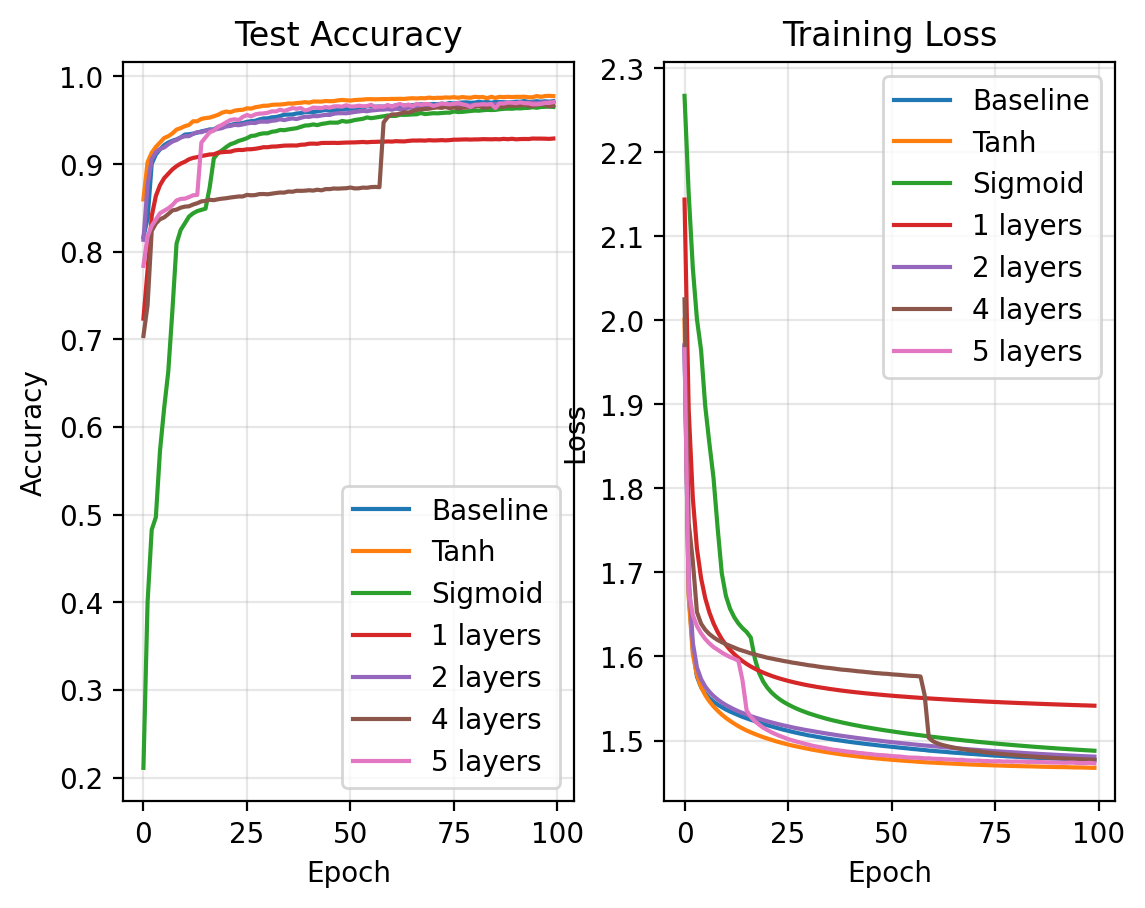

In [7]:
plt.close("all")

fig, ax = plt.subplots(1, 2, dpi=DPI)
fig.canvas.header_visible = False

# Plot accuracy curves
ax[0].plot(baseline_training_log[0], label='Baseline', linewidth=1.5)
for name, (acc_hist, _) in var_act_training_logs.items():
    ax[0].plot(acc_hist, label=f'{name.capitalize()}', linewidth=1.5)
for n_layers, (acc_hist, _) in var_layer_training_logs.items():
    ax[0].plot(acc_hist, label=f'{n_layers} layers', linewidth=1.5)

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot loss curves
ax[1].plot(baseline_training_log[1], label='Baseline', linewidth=1.5)
for name, (_, loss_hist) in var_act_training_logs.items():
    ax[1].plot(loss_hist, label=f'{name.capitalize()}', linewidth=1.5)
for n_layers, (_, loss_hist) in var_layer_training_logs.items():
    ax[1].plot(loss_hist, label=f'{n_layers} layers', linewidth=1.5)

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.show()

## 3. Evaluation

In [8]:
class BinPredEvalResult(ty.NamedTuple):
    tp: int
    fp: int
    tn: int
    fn: int

    @property
    def accuracy(self) -> float:
        return (self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn)

    @property
    def recall(self) -> float:
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0

    @property
    def precision(self) -> float:
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0

    @property
    def f1_score(self) -> float:
        prec = self.precision
        rec = self.recall
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

### 3.1. Precision, Recall and F1